https://medium.com/mlearning-ai/image-super-resolution-using-edsr-and-wdsr-f4de0b00e039

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.data.experimental import AUTOTUNE
os.chdir('/content/drive/MyDrive/HW4_dataset')

# Data preparation and preprocessing

In [6]:
class DATASET_HW4:
    ''' This class will download data at root directory and 
    directly we can use data for training'''

    def __init__(self,
                 scale=3, 
                 subset='train', # train or validation
                 images_dir='new', # image directory
                 caches_dir='caches'): # caches directory

        print("init")     

        # scale condition
        if scale == 3 :
            self.scale = scale
        else:
            raise ValueError(f'scale value must be in ${_scales}')
        
        # subset condition 'train' or 'validation'
        if subset == 'train':
            self.image_ids = range(0, 256)
        elif subset == 'valid':
            self.image_ids = range(256, 291)
        else:
            raise ValueError("subset must be 'train' or 'valid'")

        self.subset = subset
        self.images_dir = images_dir
        self.caches_dir = caches_dir

        # create directories if not already exist
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)


    # LR and HR images dir have paths of Low resolution and High resolution images.
    def _LR_images_dir(self):
        return 'new/train_lr'

    def _HR_images_dir(self):
        return 'new/train_hr'

    

    

    # LR and HR image files function have absolute path of each LR and HR image files.

    def _LR_image_files(self):
        '''It returns Low resolution images absolute path'''
        images_dir = self._LR_images_dir()

        return [os.path.join(images_dir, 
                             f'{image_id}.png') for image_id in self.image_ids]

    def _HR_image_files(self):
        '''It returns High resolution images absolute path'''
        images_dir = self._HR_images_dir()
        return [os.path.join(images_dir, 
                             f'{image_id}.png') for image_id in self.image_ids]
    
    # LR and HR cache file function have cache files of LR and HR images
    def _LR_cache_file(self):
        '''It returns cache file path of low resolution images'''
        return os.path.join(self.caches_dir, 
                            f'{self.subset}_LR_X{self.scale}.cache')

    def _HR_cache_file(self):
        ''' It returns cache file path of high resolution images'''
        return os.path.join(self.caches_dir, f'{self.subset}_HR.cache')

    # LR and HR cache index function have index of cache files
    def _LR_cache_index(self):
        ''' It returns index of LR cache file'''
        return f'{self._LR_cache_file()}.index'

    def _HR_cache_index(self):
        ''' It returns index of HR cache file index'''
        return f'{self._HR_cache_file()}.index'


    # -----------------------------------------------------------
    #  Static methods
    # -----------------------------------------------------------
    
    @staticmethod
    def _Images_dataset(image_files):
        # this function decode png files in an efficient way
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3),
                    num_parallel_calls=AUTOTUNE)
        return ds

    @staticmethod
    def _populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')

    # -----------------------------------------------------------
    #  Create LR_dataset and HR_dataset
    # -----------------------------------------------------------

    def LR_dataset(self):
        print("LR_dataset")      
        print(self._LR_image_files())
        ds = self._Images_dataset(self._LR_image_files()).cache(self._LR_cache_file())

        if not os.path.exists(self._LR_cache_index()):
            self._populate_cache(ds, self._LR_cache_file())

        return ds

    def HR_dataset(self):
        print("HR_dataset")       
        print(self._HR_image_files())
        ds = self._Images_dataset(self._HR_image_files()).cache(self._HR_cache_file())

        if not os.path.exists(self._HR_cache_index()):
            self._populate_cache(ds, self._HR_cache_file())

        return ds
    
    # -----------------------------------------------------------
    #  Final Dataset
    # -----------------------------------------------------------

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        # take LR and HR image Symanteneously
        ds = tf.data.Dataset.zip((self.LR_dataset(), self.HR_dataset()))
        # random transform will apply only on train dataset
        if random_transform:
            # random cropping
            ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=self.scale),
                        num_parallel_calls=AUTOTUNE)
            # random rotate
            ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
            # random flip
            ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
        # ds.batch() will take images in given batch size
        ds = ds.batch(batch_size)
        # it will repeat dataset. if repeat_count() = None then infinite cardinality
        ds = ds.repeat(repeat_count)
        # ds.prefetch() will prefetch data for given buffer_size
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

# Download Archive function extracts High Resolution and LR Resolution images.

# Image augmentation like cropping, rotating, flipping

In [36]:
# -----------------------------------------------------------
#  Augmentation (crop, flip, rotate)
# -----------------------------------------------------------

def random_crop(lr_img, hr_img, hr_crop_size=78, scale=3):
    ''' This function crops lr(47x47) and hr(96x96) images'''
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + hr_crop_size, hr_width:hr_width + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

def random_flip(lr_img, hr_img):
    ''' This function will flip imag left_right randomly'''
    random = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(random < 0.5,lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))
        
def random_rotate(lr_img, hr_img):
    ''' This function will rotate image randomly to 90 degree'''
    rand = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rand), tf.image.rot90(hr_img, rand)

In [37]:
hw4_train = DATASET_HW4(scale=3, subset='train')
hw4_valid = DATASET_HW4(scale=3, subset='valid')

init
init


In [38]:
train_ds = hw4_train.dataset(batch_size=16, random_transform=True)
valid_ds = hw4_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

LR_dataset
['new/train_lr/0.png', 'new/train_lr/1.png', 'new/train_lr/2.png', 'new/train_lr/3.png', 'new/train_lr/4.png', 'new/train_lr/5.png', 'new/train_lr/6.png', 'new/train_lr/7.png', 'new/train_lr/8.png', 'new/train_lr/9.png', 'new/train_lr/10.png', 'new/train_lr/11.png', 'new/train_lr/12.png', 'new/train_lr/13.png', 'new/train_lr/14.png', 'new/train_lr/15.png', 'new/train_lr/16.png', 'new/train_lr/17.png', 'new/train_lr/18.png', 'new/train_lr/19.png', 'new/train_lr/20.png', 'new/train_lr/21.png', 'new/train_lr/22.png', 'new/train_lr/23.png', 'new/train_lr/24.png', 'new/train_lr/25.png', 'new/train_lr/26.png', 'new/train_lr/27.png', 'new/train_lr/28.png', 'new/train_lr/29.png', 'new/train_lr/30.png', 'new/train_lr/31.png', 'new/train_lr/32.png', 'new/train_lr/33.png', 'new/train_lr/34.png', 'new/train_lr/35.png', 'new/train_lr/36.png', 'new/train_lr/37.png', 'new/train_lr/38.png', 'new/train_lr/39.png', 'new/train_lr/40.png', 'new/train_lr/41.png', 'new/train_lr/42.png', 'new/trai

In [39]:
# train data has Infinite cardinality because of ds.repeat()
print((train_ds.cardinality() == tf.data.INFINITE_CARDINALITY).numpy())

True


In [40]:
print('train_ds cardinality is ==> ', train_ds.cardinality().numpy())
print('valid_ds cardinality is ==> ', valid_ds.cardinality().numpy())

train_ds cardinality is ==>  -1
valid_ds cardinality is ==>  35


In [41]:
# function to plot Low and High resolution images

def plot_images(tf_dataset,n_rows,figsize=(30,30)):
    # subplots
    fig,axes = plt.subplots(nrows =n_rows, ncols = 2, figsize=figsize)
    for ax in axes.flatten():
        ax.axis('off')
    count = -1
    for lr, hr in tf_dataset.take(n_rows).as_numpy_iterator():
        count+=1
        print('LR Shape is {} and HR shape is {}'.format(lr[0].shape,hr[0].shape))
        axes[count,0].set_title('Low resolution',fontdict={'fontsize': 20,'fontweight': 'bold'})
        axes[count,0].imshow(lr[0])
        axes[count,1].set_title('High Resolution',fontdict={'fontsize': 20,'fontweight': 'bold'})
        axes[count,1].imshow(hr[0])


LR Shape is (46, 88, 3) and HR shape is (138, 264, 3)
LR Shape is (55, 79, 3) and HR shape is (165, 237, 3)


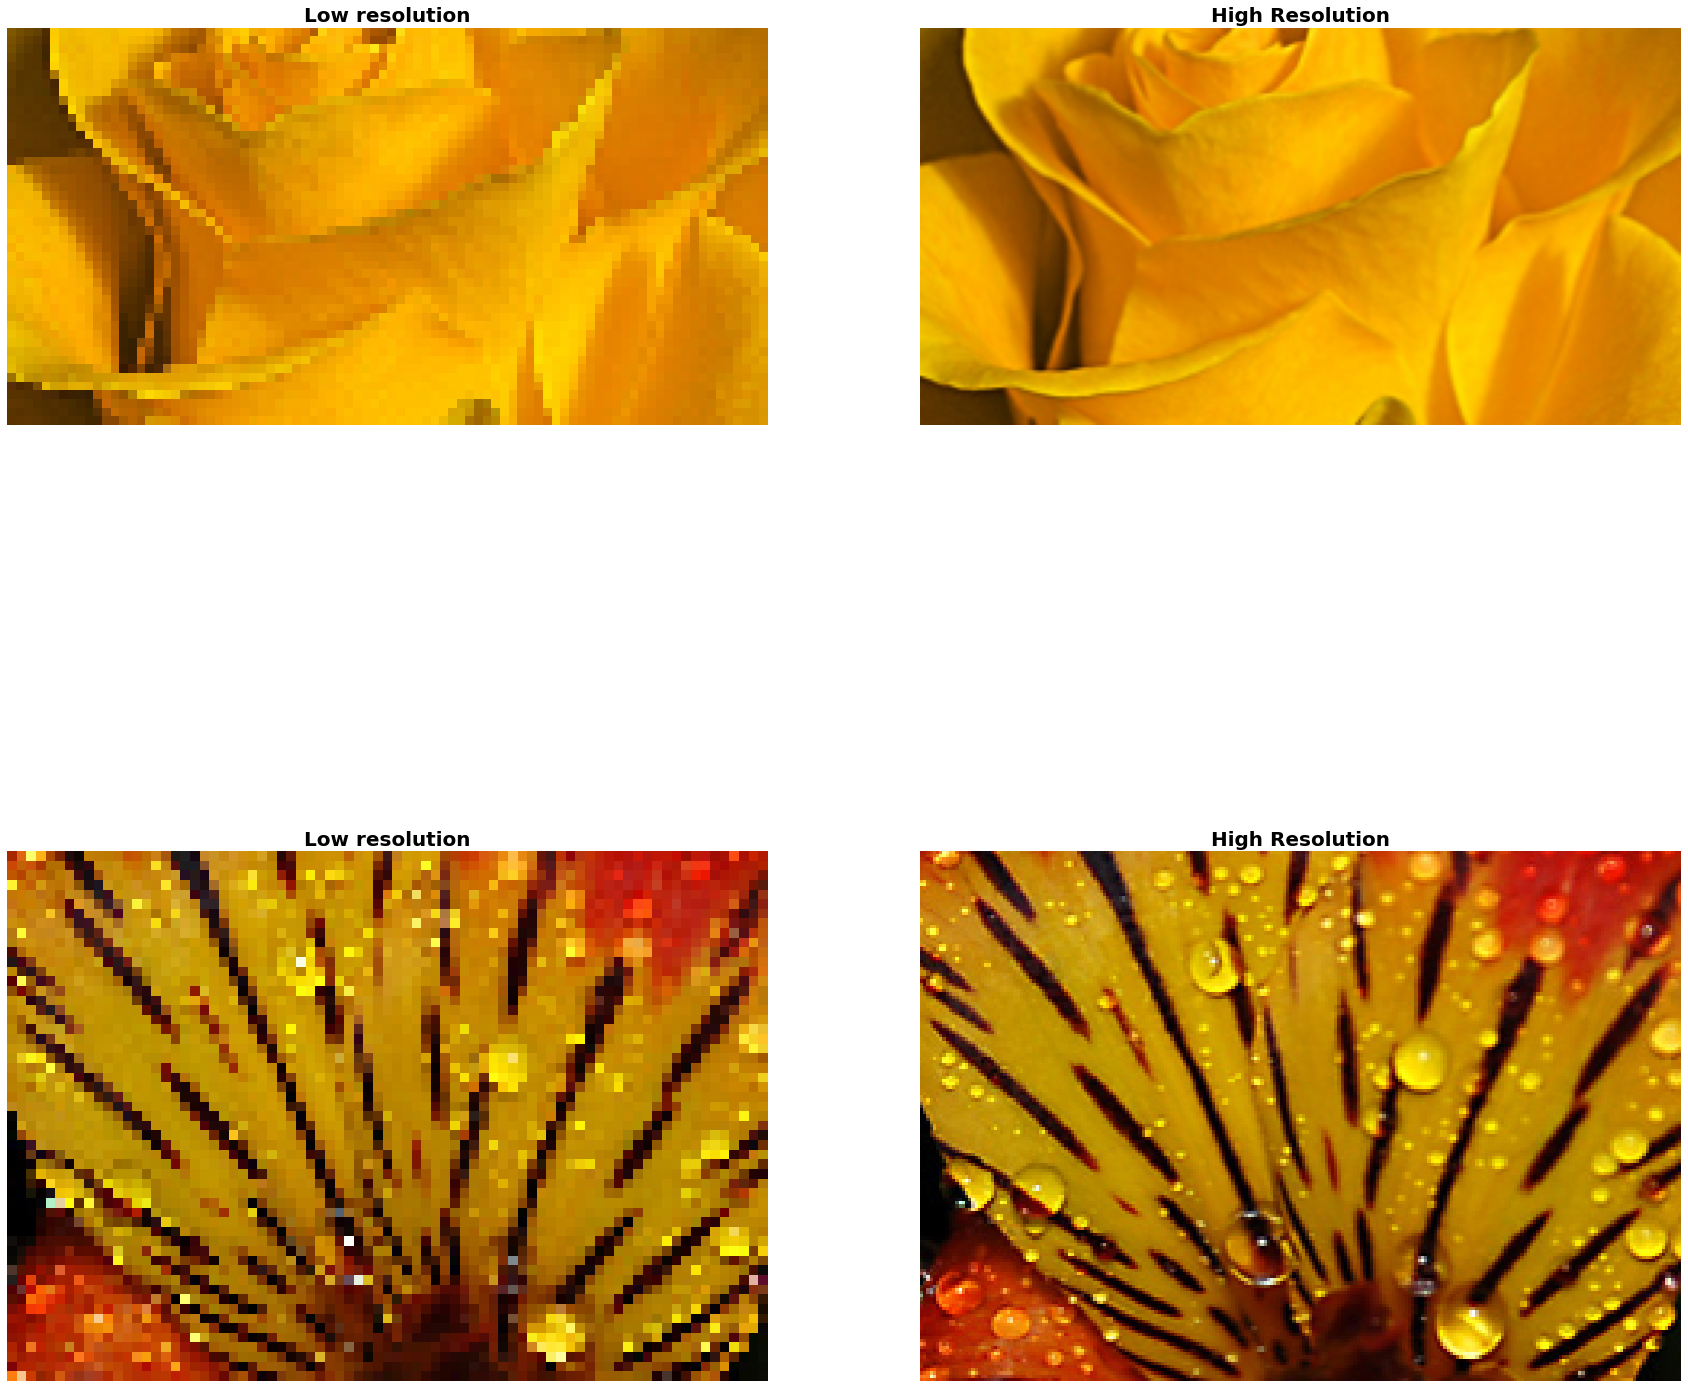

In [42]:
# Low and High resolution validation dataset
plot_images(valid_ds,2)

LR Shape is (26, 26, 3) and HR shape is (78, 78, 3)
LR Shape is (26, 26, 3) and HR shape is (78, 78, 3)


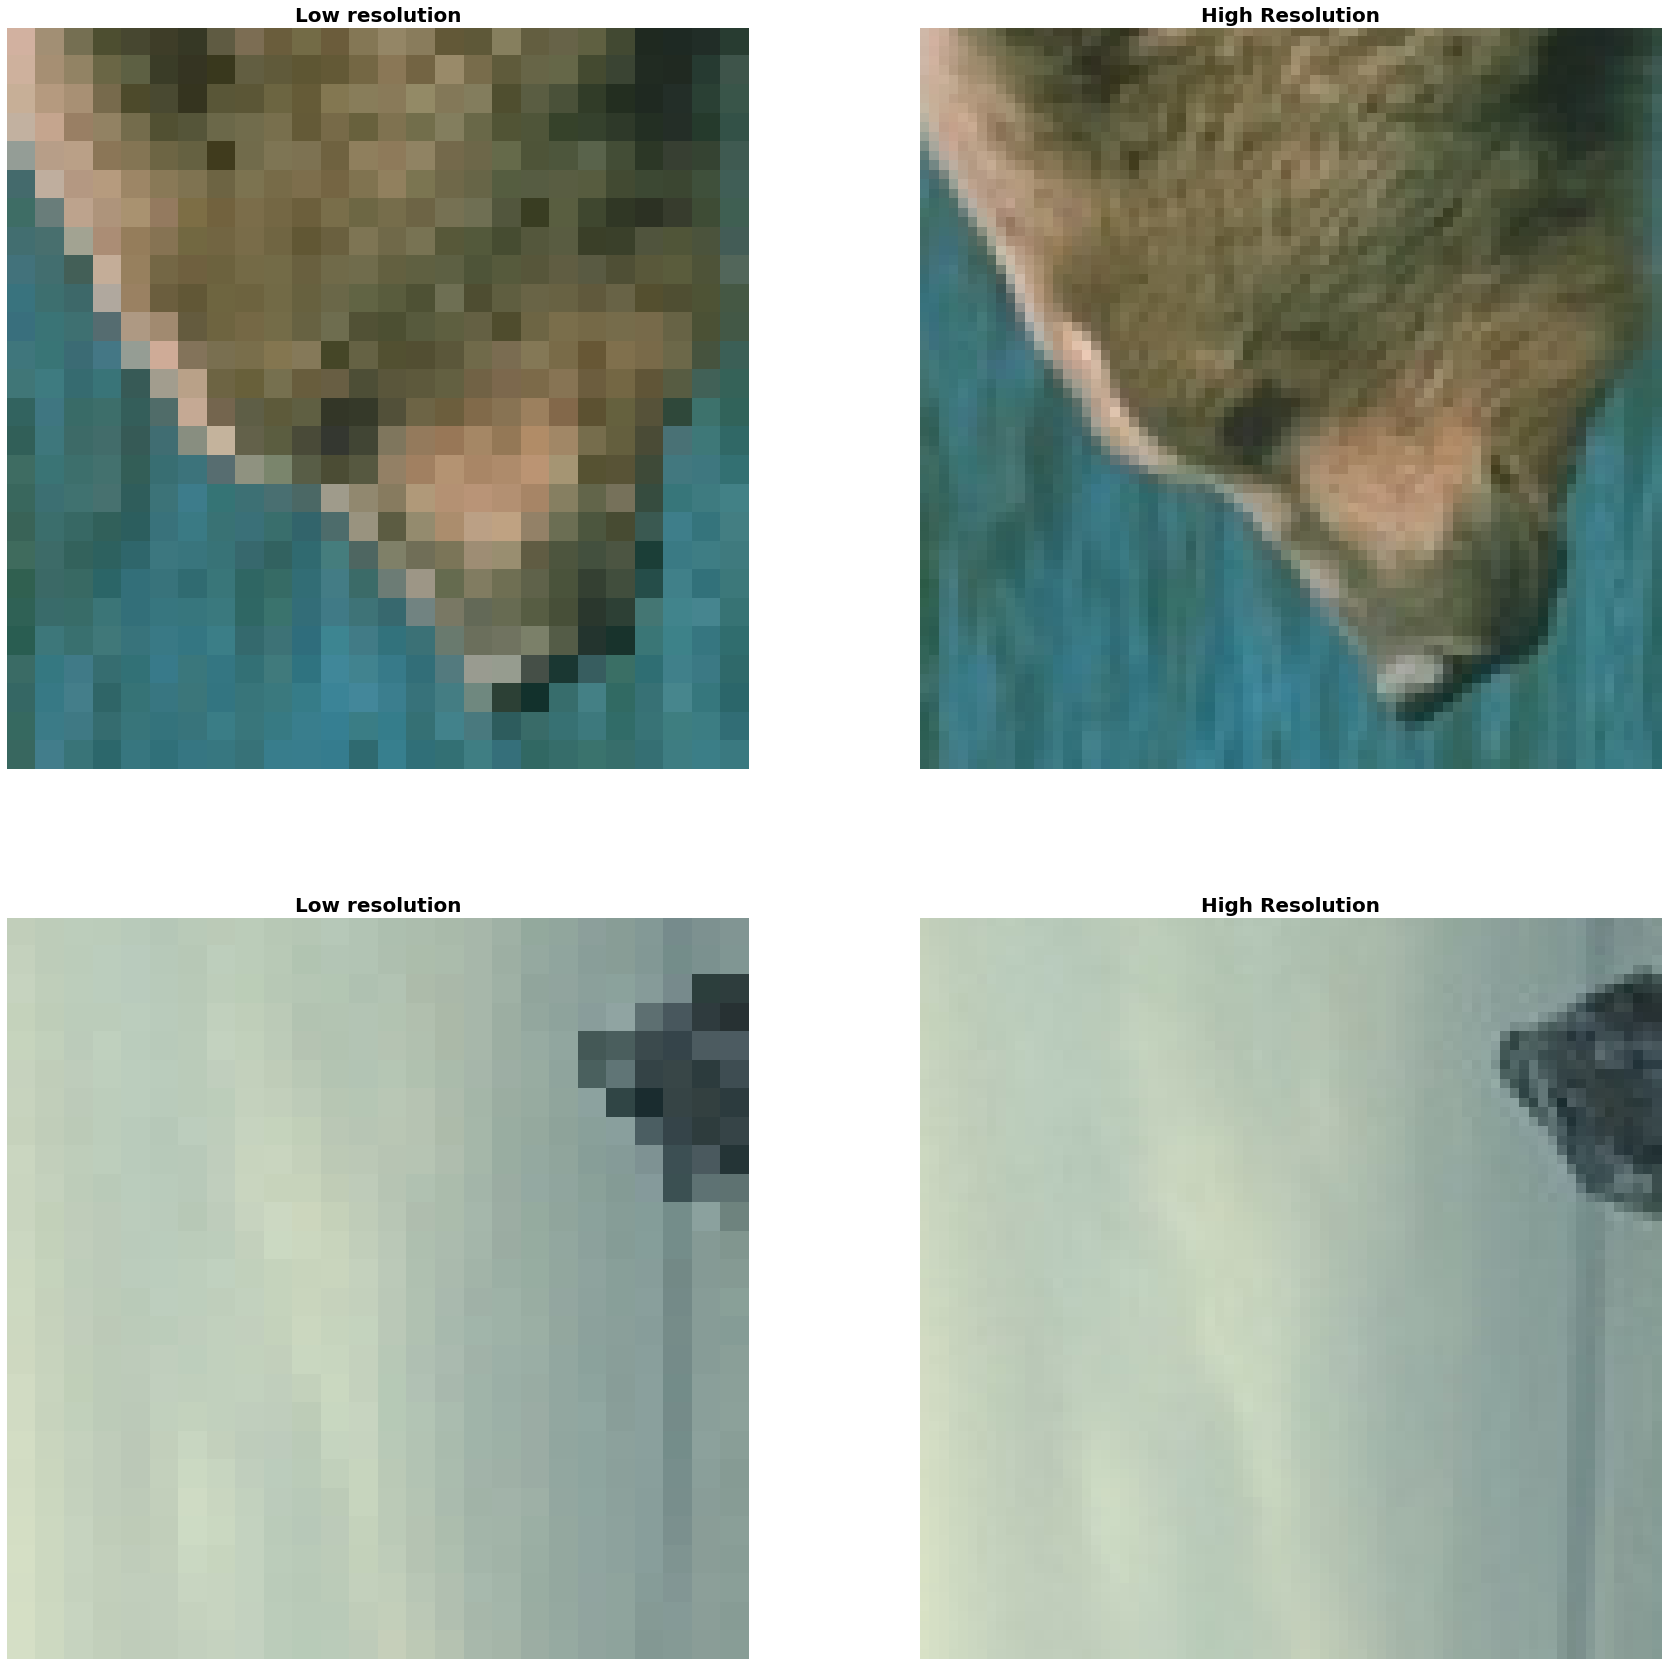

In [43]:
# Low and High resolution images of train dataset
plot_images(train_ds,2)

PSNR value ==>  30.299551
SSIM value ==>  0.9214435


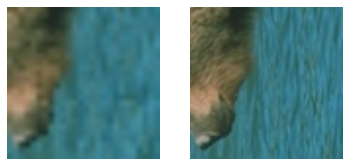

In [44]:
fig,axes = plt.subplots(nrows =1, ncols = 2)
for ax in axes.flatten():
        ax.axis('off')
for lr,hr in train_ds:
    #LR = tf.cast(lr, tf.float32)
    LR = tf.image.resize(lr, size=(512,512))
    HR = tf.image.resize(hr, size=(512,512))
    #print(LR)
    LR = tf.clip_by_value(LR, 0, 255)
    HR = tf.clip_by_value(HR, 0, 255)
    # round up values
    LR = tf.round(LR)
    HR = tf.round(HR)
    # change dtype to unint8
    LR = tf.cast(LR, tf.uint8)
    HR = tf.cast(HR, tf.uint8)
    #print(LR)
    axes[0].imshow(LR[0])
    axes[1].imshow(HR[0])
    psnr_value = tf.image.psnr(HR, LR, max_val=255).numpy()
    ssim = tf.image.ssim(HR,LR,max_val=255)
    print('PSNR value ==> ',psnr_value[0])
    print("SSIM value ==> ",ssim.numpy()[0])
    break


PSNR value ==>  34.160484
SSIM value ==>  0.9437162


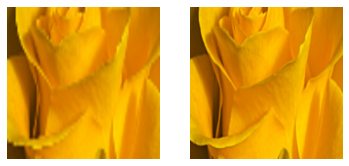

In [45]:
fig,axes = plt.subplots(nrows =1, ncols = 2)
for ax in axes.flatten():
        ax.axis('off')
for lr,hr in valid_ds :
    #LR = tf.cast(lr, tf.float32)
    LR = tf.image.resize(lr, size=(512,512))
    HR = tf.image.resize(hr, size=(512,512))
    #print(LR)
    LR = tf.clip_by_value(LR, 0, 255)
    HR = tf.clip_by_value(HR, 0, 255)
    # round up values
    LR = tf.round(LR)
    HR = tf.round(HR)
    # change dtype to unint8
    LR = tf.cast(LR, tf.uint8)
    HR = tf.cast(HR, tf.uint8)
    #print(LR)
    axes[0].imshow(LR[0])
    axes[1].imshow(HR[0])
    psnr_value = tf.image.psnr(HR, LR, max_val=255).numpy()
    ssim = tf.image.ssim(HR,LR,max_val=255)
    print('PSNR value ==> ',psnr_value[0])
    print("SSIM value ==> ",ssim.numpy()[0])
    break

# Create EDSR Model Function
* Below mentioned is Proposed Architecture of EDSR

In [46]:
import numpy as np
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

In [47]:

def normalize(x,rgb_mean=DIV2K_RGB_MEAN):
    '''This function will normalize image by substracting RGB mean from image'''
    return (x - rgb_mean) / 127.5

def denormalize(x,rgb_mean=DIV2K_RGB_MEAN):
    ''' This function will denormalize image by adding back rgb_mean'''
    return (x * 127.5 )+ rgb_mean

def shuffle_pixels(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [48]:
def ResBlock(x_input, num_filters, scaling):
    '''Thpis function Implementes Proposed ResBlock Architecture as per EDSR paper'''
    # proposed ResBlock ==> Conv --> Relu --> Conv --> Scaling(mul) --> Add
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(x_input)
    x = Conv2D(num_filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_input, x])
    return x

def Upsampling(x, scale, num_filters):
    '''This function upsampling as mentioned in EDSR paper'''
    def upsample(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(shuffle_pixels(scale=factor))(x)

    if scale == 2:
        x = upsample(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample(x, 2, name='conv2d_1_scale_2')
        x = upsample(x, 2, name='conv2d_2_scale_2')

    return x


def EDSR(scale, num_filters=64, res_blocks=8, res_block_scaling=None):
    x_input = Input(shape=(None, None, 3))
    # Normalize input with DIV2K_RGB_MEAN
    x = Lambda(normalize)(x_input)
    
    # assign value of x to x_res block for further operations
    x = x_res_block = Conv2D(num_filters, 3, padding='same')(x)

    # Goes in number of res block
    for i in range(res_blocks):
        x_res_block = ResBlock(x_res_block, num_filters, res_block_scaling)
    # convolution
    x_res_block = Conv2D(num_filters, 3, padding='same')(x_res_block)
    # add res_block output and original normalizwd input
    x = Add()([x, x_res_block])

    # upsampling
    x = Upsampling(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)
    
    # denormalize to get back original form
    x = Lambda(denormalize)(x)
    return Model(x_input, x, name="EDSR")


In [49]:
e = EDSR(3,res_blocks=16)

In [50]:
e.summary()

Model: "EDSR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, None, None, 6 1792        lambda_6[0][0]                   
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, None, None, 6 36928       conv2d_70[0][0]                  
_______________________________________________________________________________________________

# Create Training Class

In [51]:
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy) 
import time
import os

In [52]:
os.makedirs('checkpoint/edsr/',exist_ok=True)

In [53]:
class Training_pipeline:
    def __init__(self, model, loss, learning_rate, checkpoint_directory='/checkpoint/edsr'):
        # current time
        self.start = None
        # initialize loss
        self.loss = loss
        # checkpoint initialize
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                              psnr=tf.Variable(-1.0),
                                              ssim = tf.Variable(-1.0),
                                              optimizer=tf.keras.optimizers.Adam(learning_rate,epsilon=1e-08),
                                              model=model)
        # checkpoint manager initialize
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                             directory=checkpoint_directory,
                                                             max_to_keep=3)
        # restore letest checkpoint
        self.restore()
        
    @property
    def model(self):
        return self.checkpoint.model

    def train_model(self, train_dataset, validation_dataset, steps, evaluate_every=1000, save_best_only=False):
        # initilize mean metric
        loss_mean = tf.keras.metrics.Mean()
        # call heckpoint manager
        checkpoint_manager = self.checkpoint_manager
        # call checkpoint
        checkpoint = self.checkpoint

        self.start = time.perf_counter()
        # Iterating through train ds
        for lr, hr in tqdm(train_dataset.take(steps - checkpoint.step.numpy())):
            # adding 1 to checkpoint step
            checkpoint.step.assign_add(1)
            # get step value
            step = checkpoint.step.numpy()
            # get loss 
            loss = self.training_step(lr, hr)
            # get mean loss
            loss_mean(loss)
            
            # evaluate at every 1000 steps
            if step % evaluate_every == 0:
                # get loss mean at every 1000 step
                loss_value = loss_mean.result()
                # reset loss mean object 
                loss_mean.reset_states()
                # Compute psnr on validation dataset
                psnr = self.get_psnr(validation_dataset)
                # Compute ssim on validaton dataset
                ssim = self.get_ssim(validation_dataset)
                # get total time duration
                duration = time.perf_counter() - self.start
                # print loss, psnr and duration
                print(f'{step}/{steps}: LOSS = {loss_value.numpy():.4f},PSNR = {psnr.numpy():3f}, SSIM = {ssim.numpy():3f},Time = ({duration:.2f}s)')

                
                if save_best_only and psnr <= checkpoint.psnr:
                    self.start = time.perf_counter()
                    # skip saving checkpoint, if psnr not improving
                    continue
                # If psnr improved then save 
                checkpoint.psnr = psnr
                # save checkpoint manager 
                checkpoint_manager.save()

                self.start = time.perf_counter()


    @tf.function
    def training_step(self, lr, hr):
        with tf.GradientTape() as tape:
            # convert dtypes
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            # get sr image from trained model
            sr = self.checkpoint.model(lr, training=True)
            # get loss value 
            get_loss_value = self.loss(hr, sr)

        gradients = tape.gradient(get_loss_value, self.checkpoint.model.trainable_variables)
        self.checkpoint.optimizer.apply_gradients(zip(gradients, self.checkpoint.model.trainable_variables))

        return get_loss_value


    # evaluate (get psnr value)
    def get_psnr(self, dataset):
        psnr_values = []
        for lr, hr in dataset:
            # convert dtype to float32
            lr = tf.cast(lr, tf.float32)
            # get sr image from model
            sr = self.checkpoint.model(lr)
            # clip values to 0,255
            sr = tf.clip_by_value(sr, 0, 255)
            # round up values
            sr = tf.round(sr)
            # change dtype to unint8
            sr = tf.cast(sr, tf.uint8)
            # get psnr value
            psnr_value = tf.image.psnr(hr, sr, max_val=255)[0]
            # append psnr value
            psnr_values.append(psnr_value)
        return tf.reduce_mean(psnr_values)

    # get ssim on validation dataset
    def get_ssim(self,dataset):
        ssim_values = []
        for lr,hr in dataset:
            # convert dtype to float32
            lr = tf.cast(lr, tf.float32)
            # get sr image from model
            sr = self.checkpoint.model(lr)
            # clip values to 0,255
            sr = tf.clip_by_value(sr, 0, 255)
            # round up values
            sr = tf.round(sr)
            # change dtype to unint8
            sr = tf.cast(sr, tf.uint8)
            # get ssim value
            ssim_value = tf.image.ssim(hr, sr, max_val=255).numpy()[0]
            # append ssim value
            ssim_values.append(ssim_value)
        return tf.reduce_mean(ssim_values)

    # restore checkpoint
    def restore(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Model restored from checkpoint at step {self.checkpoint.step.numpy()}.')

In [54]:
class EdsrTraining(Training_pipeline):
    def __init__(self, model, checkpoint_dir,
                 learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                     boundaries=[200000],values=[1e-4, 5e-5])):
        
        super().__init__(model, 
                         loss = tf.keras.losses.MeanAbsoluteError(), 
                         learning_rate=learning_rate, 
                         checkpoint_directory=checkpoint_dir)

    def start_training(self, train_dataset, validation_dataset, steps=300000, evaluate_every=1000, save_best_only=True):
        super().train_model(train_dataset, validation_dataset, steps, evaluate_every, save_best_only)


In [55]:
trainer = EdsrTraining(
    model=EDSR(scale=3, num_filters=64, res_blocks=16, res_block_scaling=None), 
    checkpoint_dir= f'checkpoint/edsr')

In [56]:
trainer.start_training(train_ds,
              valid_ds.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

  0%|          | 0/300000 [00:00<?, ?it/s]

1000/300000: LOSS = 12.9186,PSNR = 26.993021, SSIM = 0.792251,Time = (34.61s)
2000/300000: LOSS = 8.0394,PSNR = 27.809616, SSIM = 0.823386,Time = (31.96s)
3000/300000: LOSS = 7.5823,PSNR = 27.976849, SSIM = 0.833138,Time = (31.79s)
4000/300000: LOSS = 7.4921,PSNR = 28.179459, SSIM = 0.842079,Time = (31.87s)
5000/300000: LOSS = 7.3837,PSNR = 28.394436, SSIM = 0.844576,Time = (31.83s)
6000/300000: LOSS = 7.1919,PSNR = 28.821539, SSIM = 0.852113,Time = (31.78s)
7000/300000: LOSS = 7.1024,PSNR = 29.002249, SSIM = 0.851853,Time = (31.49s)
8000/300000: LOSS = 7.0447,PSNR = 29.162354, SSIM = 0.853165,Time = (31.74s)
9000/300000: LOSS = 6.9777,PSNR = 29.317780, SSIM = 0.856276,Time = (31.75s)
10000/300000: LOSS = 6.9281,PSNR = 29.446115, SSIM = 0.860336,Time = (31.65s)
11000/300000: LOSS = 6.8529,PSNR = 29.561304, SSIM = 0.859534,Time = (31.72s)
12000/300000: LOSS = 6.7787,PSNR = 29.603653, SSIM = 0.862706,Time = (31.69s)
13000/300000: LOSS = 6.6922,PSNR = 29.697321, SSIM = 0.861000,Time = (31

In [57]:
trainer.restore()

Model restored from checkpoint at step 227000.


In [59]:
# evaluate on whole validationn dataset
validation_psnr = trainer.get_psnr(valid_ds)

In [60]:
print('Validation PSNR ===> ', validation_psnr.numpy())

Validation PSNR ===>  28.581675


In [61]:
trainer.model.save_weights('edsr_300000.h5')

# Train for another 50,000 steps with reduced learning rate

In [62]:
class EdsrTraining(Training_pipeline):
    def __init__(self, model, checkpoint_dir,
                 learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                     boundaries=[325000],values=[125e-7,625e-8])):
        
        super().__init__(model, 
                         loss = tf.keras.losses.MeanAbsoluteError(), 
                         learning_rate=learning_rate, 
                         checkpoint_directory=checkpoint_dir)

    def start_training(self, train_dataset, validation_dataset, steps=350000, evaluate_every=1000, save_best_only=True):
        super().train_model(train_dataset, validation_dataset, steps, evaluate_every, save_best_only)


In [63]:
trainer = EdsrTraining(
    model=EDSR(scale=3, num_filters=64, res_blocks=16, res_block_scaling=None), 
    checkpoint_dir= f'checkpoint/edsr')

Model restored from checkpoint at step 227000.


In [65]:
trainer.start_training(train_ds,
              valid_ds.take(10),
              steps=350000, 
              evaluate_every=1000, 
              save_best_only=True)

  0%|          | 0/123000 [00:00<?, ?it/s]

228000/350000: LOSS = 5.5942,PSNR = 30.400890, SSIM = 0.870236,Time = (33.38s)
229000/350000: LOSS = 5.6004,PSNR = 30.432251, SSIM = 0.870331,Time = (31.26s)
230000/350000: LOSS = 5.6064,PSNR = 30.409021, SSIM = 0.870241,Time = (31.61s)
231000/350000: LOSS = 5.6246,PSNR = 30.407907, SSIM = 0.870183,Time = (31.51s)
232000/350000: LOSS = 5.6292,PSNR = 30.416098, SSIM = 0.870726,Time = (31.56s)
233000/350000: LOSS = 5.6255,PSNR = 30.407726, SSIM = 0.870141,Time = (31.58s)
234000/350000: LOSS = 5.6152,PSNR = 30.418325, SSIM = 0.870271,Time = (31.62s)
235000/350000: LOSS = 5.6409,PSNR = 30.415400, SSIM = 0.870178,Time = (31.31s)
236000/350000: LOSS = 5.6454,PSNR = 30.376898, SSIM = 0.869668,Time = (31.19s)
237000/350000: LOSS = 5.5986,PSNR = 30.418354, SSIM = 0.870618,Time = (31.36s)
238000/350000: LOSS = 5.6116,PSNR = 30.402008, SSIM = 0.870322,Time = (31.29s)
239000/350000: LOSS = 5.6246,PSNR = 30.416607, SSIM = 0.870796,Time = (31.43s)
240000/350000: LOSS = 5.6312,PSNR = 30.397024, SSIM 

In [66]:
# evaluate on whole validationn dataset
validation_psnr = trainer.get_psnr(valid_ds)
validation_ssim = trainer.get_ssim(valid_ds)
print('Validation PSNR ===> ', validation_psnr.numpy())
print('Validation SSIM ===> ', validation_ssim.numpy())

Validation PSNR ===>  28.503714
Validation SSIM ===>  0.83838135


In [67]:
# save weights
trainer.model.save_weights('edsr_350000.h5')

In [68]:
new_model = EDSR(scale=3,res_blocks=16)
new_model.load_weights('edsr_350000.h5')

In [69]:
def get_sr_image(model, lr_batch):
    if len(lr_batch.shape) == 3 :
        lr_batch = tf.expand_dims(lr_batch,axis=0)
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch

In [70]:
from PIL import Image

def load_image(path):
    return np.array(Image.open(path))

def plot_custom_images(lr,sr,figsize = (20,10)):
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize=figsize)
    for ax in axes.flatten():
        ax.axis('off')
    axes[0].set_title('Low resolution',fontdict={'fontsize': 20,'fontweight': 'bold'})
    axes[0].imshow(lr)
    axes[1].set_title('Super Resolution(predicted)',fontdict={'fontsize': 20,'fontweight': 'bold'})
    axes[1].imshow(sr)

# This function will plot LR and HR images
def plot_sample(lr, sr,figsize=(10,10)):
    plt.figure(figsize=figsize)

    images = [lr, sr]
    titles = ['LR', 'HR']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])


# this function will plot 3 images named LR, SR(predicted) and HR(original)
def plot_images(lr,sr,hr,figsize=(10,10)):
    plt.figure(figsize=figsize)

    images = [lr, sr, hr]
    titles = ['LR', f'SR (x{sr.shape[0] // lr.shape[0]})(predicted)', 'HR(Original)']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [34.94419] and SSIM = [0.93896085]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [24.331442] and SSIM = [0.77141863]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [37.035973] and SSIM = [0.9425292]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [25.420475] and SSIM = [0.933405]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [29.5382] and SSIM = [0.9537292]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [34.82902] and SSIM = [0.9247994]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [31.520275] and SSIM = [0.88368875]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [20.704765] and SSIM = [0.6786413]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [28.782372] and SSIM = [0.7477202]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [36.89949] and SSIM = [0.92512697]
<class 'tensorflow.python.framework.ops.Ea

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [28.596272] and SSIM = [0.9054697]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [25.86362] and SSIM = [0.8858655]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [22.716263] and SSIM = [0.7613077]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [33.741425] and SSIM = [0.8774915]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [30.756924] and SSIM = [0.86010915]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [28.86374] and SSIM = [0.8967065]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [35.03151] and SSIM = [0.94672745]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [31.235508] and SSIM = [0.85178494]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [32.72675] and SSIM = [0.9311752]
<class 'tensorflow.python.framework.ops.EagerTensor'>
PSNR = [29.812502] and SSIM = [0.8977833]
<class 'tensorflow.python.framework.ops.E

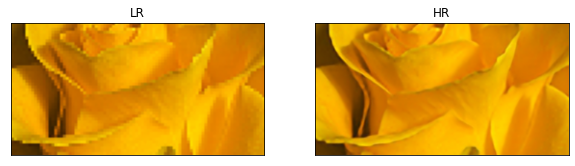

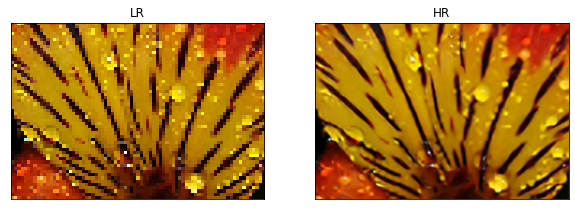

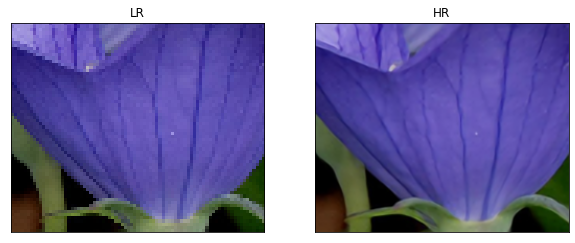

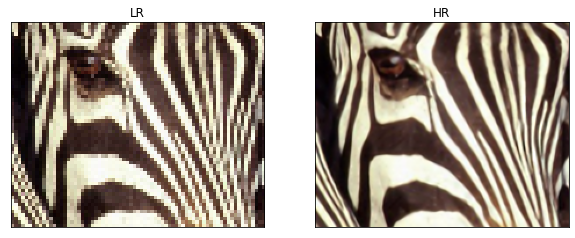

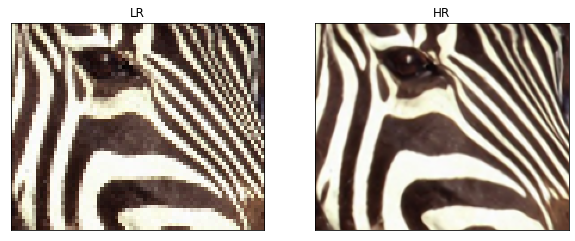

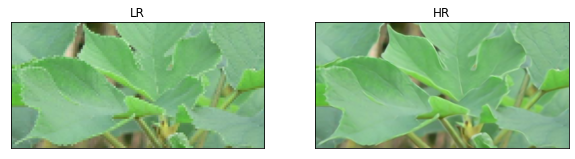

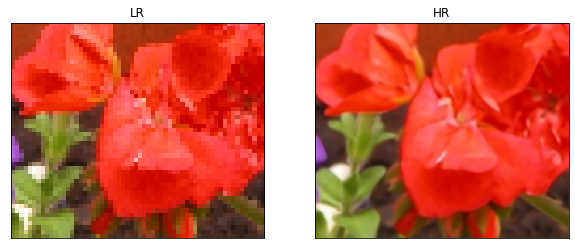

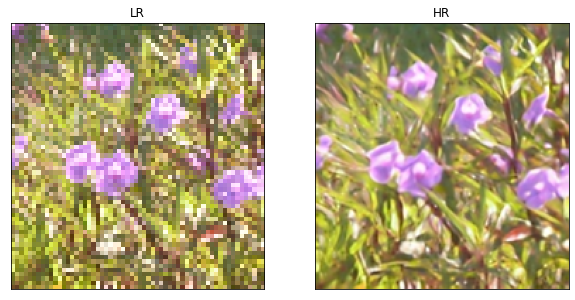

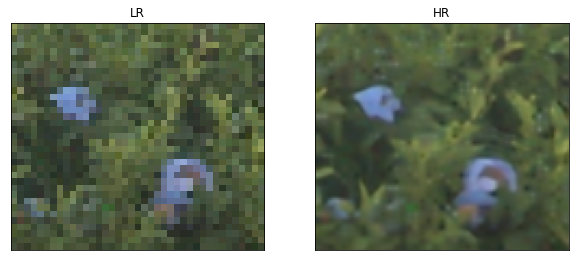

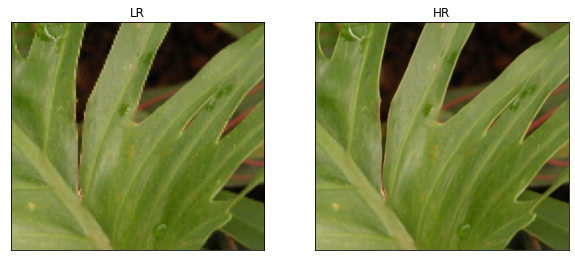

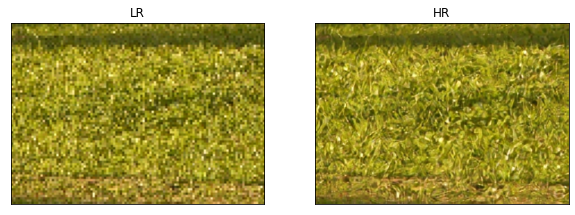

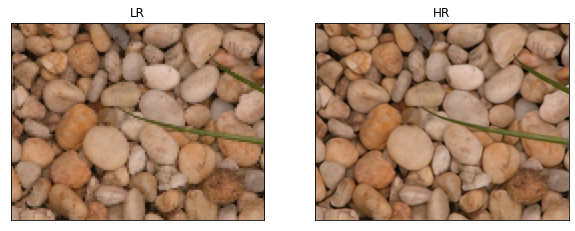

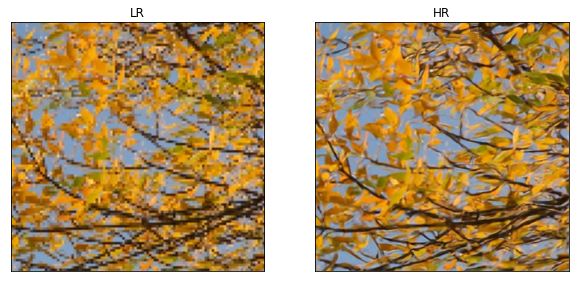

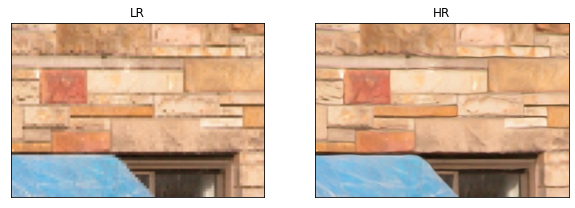

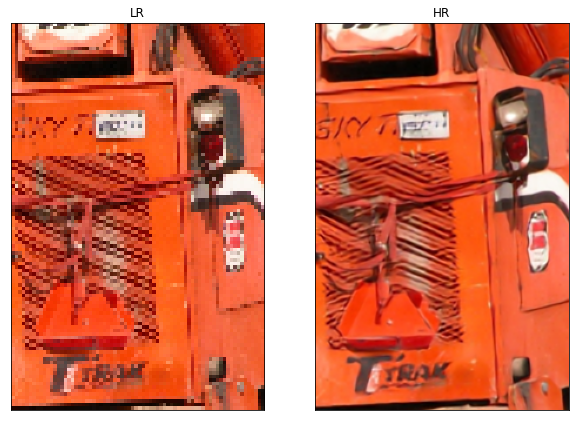

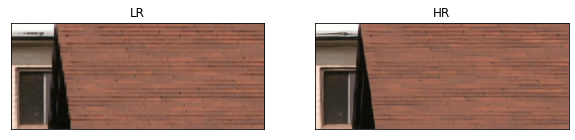

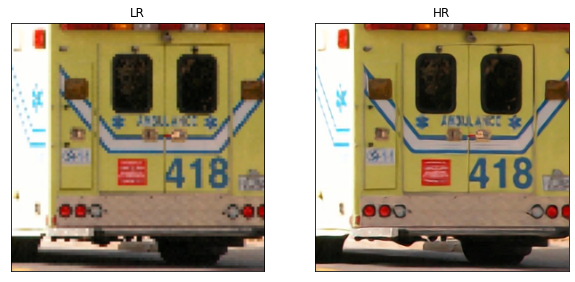

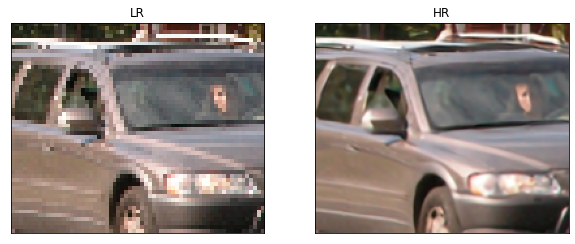

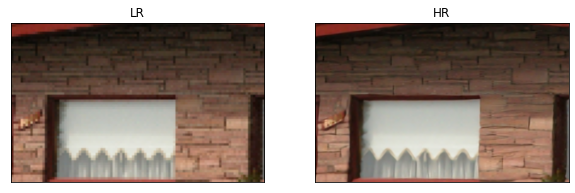

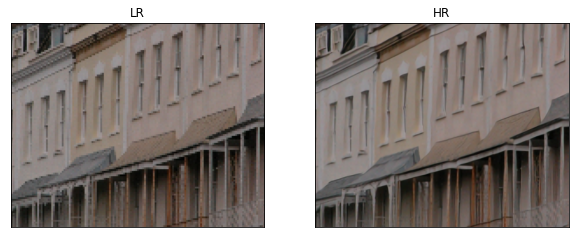

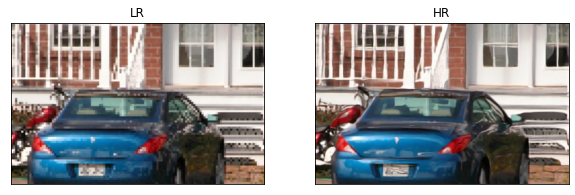

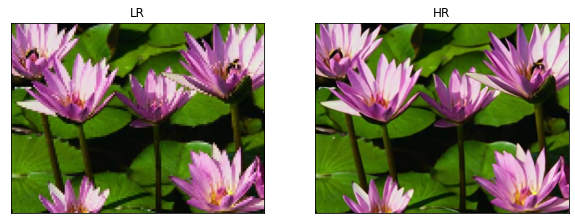

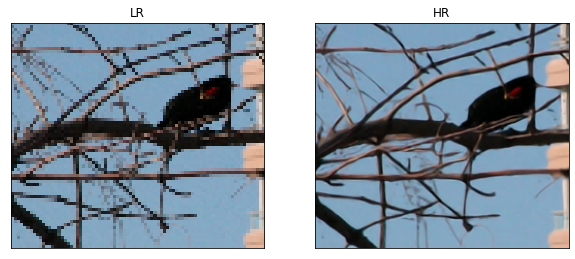

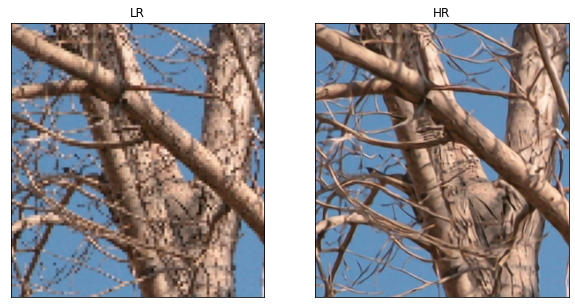

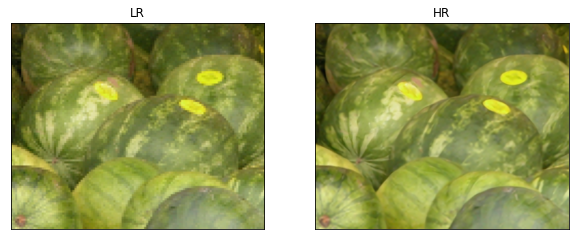

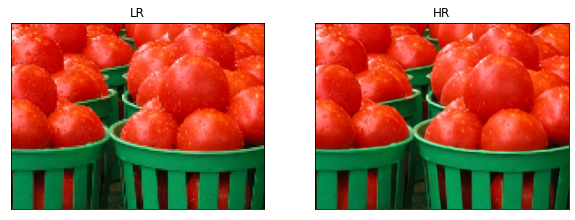

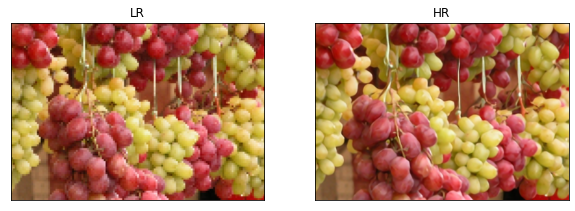

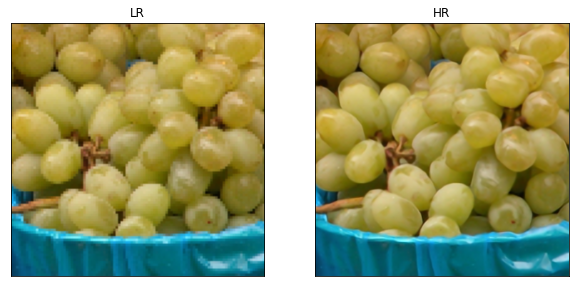

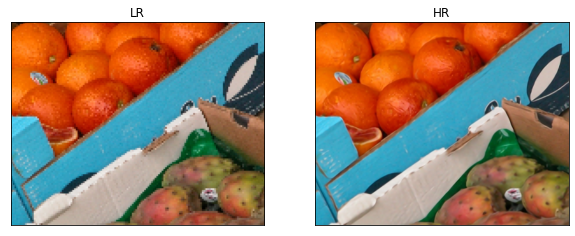

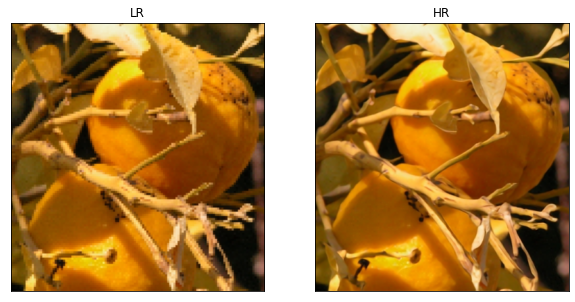

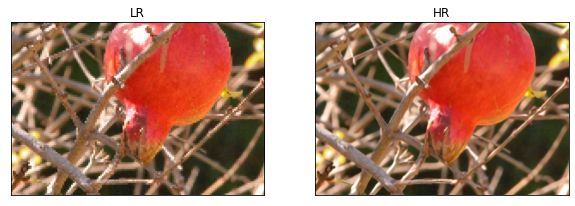

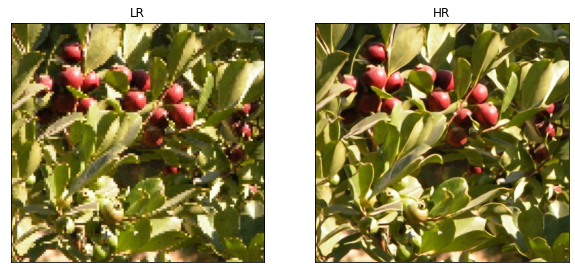

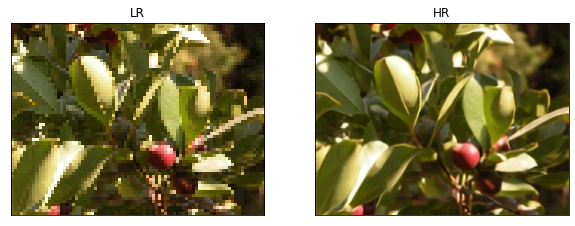

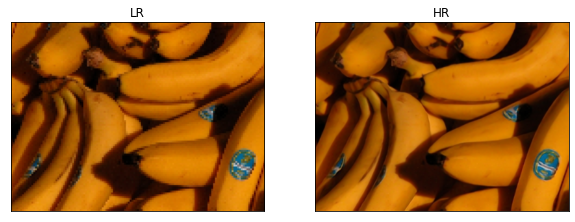

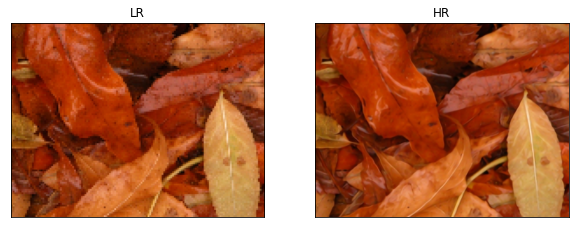

In [73]:
for lr,hr in valid_ds:
    print(type(lr))
    sr = get_sr_image(new_model,lr)
    psnr = tf.image.psnr(hr,sr,max_val=255).numpy()
    ssim = tf.image.ssim(hr,sr,max_val=255).numpy()
    print('PSNR = {} and SSIM = {}'.format(psnr,ssim))
    plot_sample(lr[0],sr[0])

In [109]:
import cv2
from google.colab.patches import cv2_imshow

test_dir = '/content/drive/MyDrive/HW4_dataset/testing_lr_images/testing_lr_images/'
for file_name in os.listdir(test_dir):
  print(file_name)
  path = test_dir + file_name
  img = cv2.imread(path)

  img = tf.expand_dims(img,axis=0)
  img = tf.cast(img, tf.float32)
  sr_img = new_model(img)
  sr_img = tf.clip_by_value(sr_img, 0, 255)
  sr_img = tf.round(sr_img)
  sr_img = tf.cast(sr_img, tf.uint8)
  result = np.reshape(sr_img.numpy(), (sr_img.numpy().shape[1], sr_img.numpy().shape[2],3))

  des = '/content/drive/MyDrive/HW4_dataset/test_result/'+file_name[:-4]+'_pred.png'
  cv2.imwrite(des,result)

00.png
01.png
02.png
03.png
04.png
05.png
06.png
07.png
08.png
09.png
10.png
11.png
12.png
13.png
